# Search Walk

In [1]:
from qiskit import *
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.gate import *
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import Gate
from qiskit.circuit.library import Diagonal

/home/jlucas/.local/lib/python3.6/site-packages/qiskit/__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,


## Useful gate

In [3]:
def diffuser(n):
    qr = QuantumRegister(n)
    diffuser = QuantumCircuit(qr)
    
    diffuser.h(qr[:])
    diffuser.x(qr[:])
    diffuser.h(qr[-1])
    diffuser.mct(qr[:-1], qr[-1])  # multi-controlled-toffoli
    diffuser.h(qr[-1])
    diffuser.x(qr[:])
    diffuser.h(qr[:])
    return diffuser.to_gate(label='D')

#diffuser(2).draw(output ='mpl')

In [4]:
def increment_gate(n):
    q_r = QuantumRegister(n)
    inc = QuantumCircuit(q_r)
    for i in range(n-1,0, -1):
        inc.mct(q_r[:i], q_r[i])
    inc.x(q_r[0])
    
    return inc.to_gate(label='INCREMENT')

In [5]:
def decrement_gate(n):
    q_r = QuantumRegister(n)
    dec = QuantumCircuit(q_r)
    
    dec.x(q_r[0])
    for i in range(1,n):
        dec.mct(q_r[:i], q_r[i])
        
    return dec.to_gate(label='DECREMENT')

In [6]:
def shift_gate(n):
    q_r_1 = QuantumRegister(n)
    q_r_2 = QuantumRegister(n)
    q_c = QuantumRegister(2)
    shift = QuantumCircuit(q_r_1, q_r_2,q_c, name = 'Shift')
    
    dec_j = decrement_gate(n)
    shift.append(dec_j, q_r_1[:])
    
    
    inc_j = increment_gate(n).control(1)
    shift.append(inc_j, [q_c[0]] + q_r_1[:])
    shift.append(inc_j, [q_c[0]] + q_r_1[:])
    
    
    shift.append(inc_j, [q_c[1]] + q_r_1[:])

    
    dec_i = decrement_gate(n).control(1)
    shift.append(dec_i, [q_c[1]] + q_r_2[:])
    
    dec = decrement_gate(n).control(2)
    inc = increment_gate(n).control(2)
    shift.append(inc, q_c[:] + q_r_2[:])
    shift.append(inc, q_c[:] + q_r_2[:])
    shift.append(dec, q_c[:] + q_r_1[:])
    shift.append(dec, q_c[:] + q_r_1[:])
    
    
    #shift.x( q_c[1])
        
    return shift.to_gate(label='SHIFT')
#shift_gate(n).draw(output ='mpl')

In [8]:
def grover_oracle(n, sol):
    diagonal_elements = [1]*(2**n)
    diagonal_elements[sol]= -1
    oracle = Diagonal(diagonal_elements)
    #print(diagonal_elements)
    oracle.name = "O$_{f}$"
    return oracle.to_gate()

#grover_oracle(2, 2).draw(output ='mpl')

## Useful functions

In [9]:
def simulate(circuit, shots=1024):
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circuit, backend = simulator, shots=shots).result()
    counts = result.get_counts(circuit)
    return counts

In [10]:
def grover_dec_bar(n,counts):
    t= 2**(n)
    x= range(t)
    y= [0]*t
    for num in list(counts.keys()) :
        no = int(num, base = 2)
        y[no]+= counts[num]
    y = np.array(y)/sum(y)

    plt.bar(x,y)

In [11]:
def show(n,counts, m=2):
    grid = np.zeros((2**(n),2**(n)))
    for num in list(counts.keys()) :
        i = int(num[m+1:n+m+1], base = 2)
        #i = i if i<2**(n-1) else i-(2**n)
        j = int(num[m+n+2:m+2*n+2], base = 2)
        #j = j if j<2**(n-1) else j-(2**n)
        #print(num, "i ='", i, "',j ='",j,"'", counts[num])
        #grid[i + 2**(n-1)-1,j +2**(n-1)-1]= 1024 - counts[num]
        grid[i,j]+=counts[num]
    print(grid)
    return grid

## Walk on the NxN grid with self-loop

[1, 1, 1, 1, 0, 0, 0, 0]


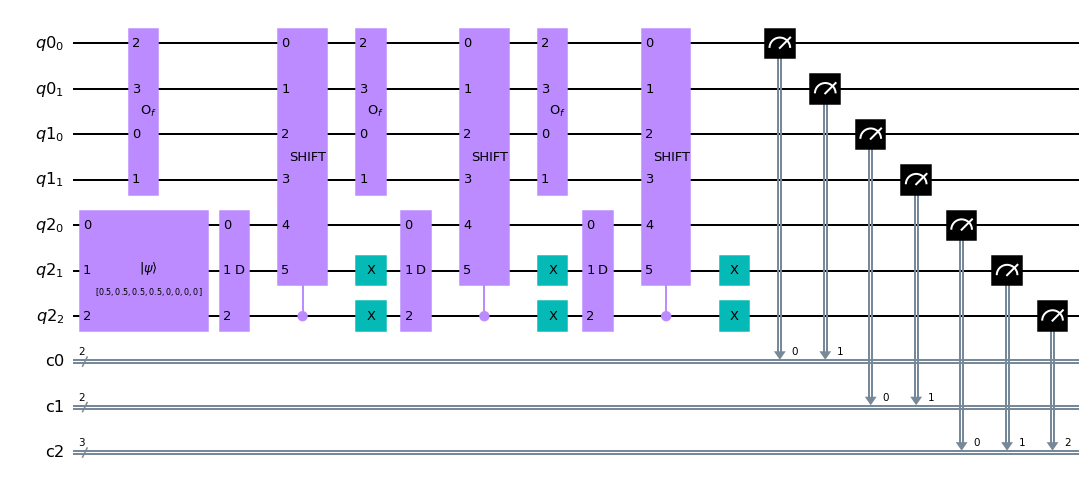

In [13]:
t = 3
n = 2
m=3
a=0
i,j = 0,0
q_reg_i = QuantumRegister(n)
q_reg_j = QuantumRegister(n)
q_coin = QuantumRegister(3)
c_reg_i = ClassicalRegister(n)
c_reg_j = ClassicalRegister(n)
c_coin = ClassicalRegister(3)


circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )


a_string = "1 "*(2**(m-1))
a_list = a_string.split()
map_object = map(int, a_list)
    
    
vector =  list(map_object)+[a]*(2**(m-1))
print(vector)
initial_state = vector/np.linalg.norm(vector)
    
circuit.initialize(initial_state, q_coin[:]) 

#circuit.h(q_coin[2])

coin = diffuser(3)
oracle = grover_oracle(2*n, i+j*2**n)
shift = shift_gate(n).control(1)

for _ in range(t) :
    circuit.append(coin, q_coin[:])
    circuit.append(oracle, q_reg_j[:]+ q_reg_i[:])
    circuit.append(shift, [q_coin[2]] + q_reg_i[:] + q_reg_j[:] + q_coin[:2])
    circuit.x( q_coin[1:])
    


circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])

circuit.draw(output ='mpl')

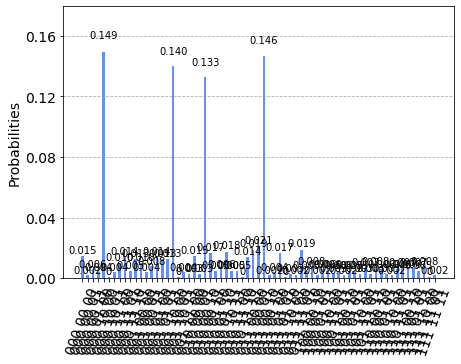

In [14]:
counts = simulate(circuit)
plot_histogram(counts)

[[ 59.  30. 310.  33.]
 [ 27.  50.   7.  50.]
 [315.   5.   0.  13.]
 [ 20.  50.  11.  44.]]


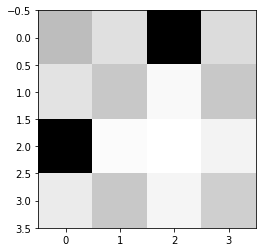

In [15]:
plt.imshow(show(n,counts,3)**(1.1), interpolation='nearest',vmin=0, vmax=1024/3, cmap='binary')

### Search walk on a N-N grid with self-loop

In [16]:
a=0.04
t = 10
n = 2
m=3
i,j = 2,3
q_reg_i = QuantumRegister(n)
q_reg_j = QuantumRegister(n)
q_coin = QuantumRegister(3)
c_reg_i = ClassicalRegister(n)
c_reg_j = ClassicalRegister(n)
c_coin = ClassicalRegister(3)

circuit = QuantumCircuit(q_reg_i, q_reg_j, q_coin, c_reg_i, c_reg_j, c_coin )



a_string = "1 "*(2**(m-1))
a_list = a_string.split()
map_object = map(int, a_list)
    
    
vector =  list(map_object)+[a]*(2**(m-1))
print(vector)
initial_state = vector/np.linalg.norm(vector)
    
circuit.initialize(initial_state, q_coin[:]) 

circuit.h(q_reg_j[:] + q_reg_i[:])

coin = diffuser(3)
oracle = grover_oracle(2*n, i+j*2**n)
shift = shift_gate(n).control(1)

for _ in range(t) :
    circuit.append(coin, q_coin[:])
    circuit.append(oracle, q_reg_j[:]+ q_reg_i[:])
    circuit.append(shift, [q_coin[2]] + q_reg_i[:] + q_reg_j[:] + q_coin[:2])
    circuit.x( q_coin[1:])


circuit.measure(q_reg_i[:] + q_reg_j[:] + q_coin[:], c_reg_i[:] + c_reg_j[:] + c_coin[:])

#circuit.measure(q_coin[:], c_coin[:])
#circuit.draw(output ='mpl')

[1, 1, 1, 1, 0.04, 0.04, 0.04, 0.04]


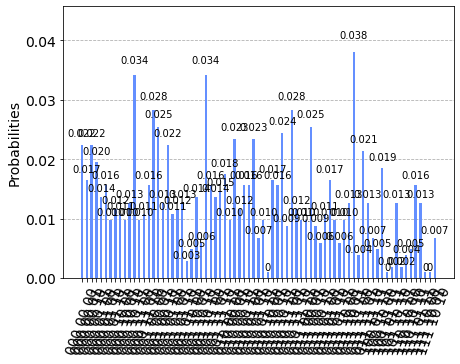

In [17]:
counts = simulate(circuit)
plot_histogram(counts)

[[ 72.  93.  57.  65.]
 [ 52.  69.  40.  51.]
 [ 51.  55.  60. 134.]
 [ 39.  76.  56.  54.]]


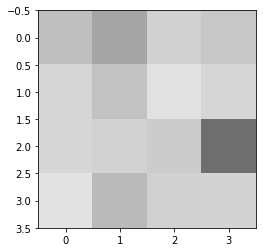

In [18]:
plt.imshow(show(n,counts,3)**(1.3), interpolation='nearest',vmin=0, vmax=1024, cmap='binary')